# Import and Data Processing on Historical Data

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.optimizers import Adam
from keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from gensim import corpora, models
import nltk
import string
from collections import Counter
from wordcloud import WordCloud
from keras.optimizers import Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
# Load the data
data_path = 'historical_price_data.csv'
stock_df = pd.read_csv(data_path)

# Display the first few rows of the dataframe
stock_df.head()

date   open   high    low  close    volume stock
0  08/02/2013  15.07  15.12  14.63  14.75   8407500   AAL
1  11/02/2013  14.89  15.01  14.26  14.46   8882000   AAL
2  12/02/2013  14.45  14.51  14.10  14.27   8126000   AAL
3  13/02/2013  14.30  14.94  14.25  14.66  10259500   AAL
4  14/02/2013  14.94  14.96  13.16  13.99  31879900   AAL

In [9]:
# Check for missing values
missing_values = stock_df.isnull().sum()

# Check the data types of each column
data_types = stock_df.dtypes

missing_values, data_types

(date       0
 open      11
 high       8
 low        8
 close      0
 volume     0
 stock      0
 dtype: int64,
 date       object
 open      float64
 high      float64
 low       float64
 close     float64
 volume      int64
 stock      object
 dtype: object)

In [10]:
# Create a new DataFrame with missing values filled
df_filled = stock_df.copy()

df_filled['open'] = stock_df['open'].fillna(stock_df['open'].mean())
df_filled['high'] = stock_df['high'].fillna(stock_df['high'].mean())
df_filled['low'] = stock_df['low'].fillna(stock_df['low'].mean())

# Check if the NaN values are replaced in the new DataFrame
print(df_filled.isna().sum())


date      0
open      0
high      0
low       0
close     0
volume    0
stock     0
dtype: int64


In [11]:
# Convert 'date' column to datetime format
df_filled['date'] = pd.to_datetime(df_filled['date'], dayfirst=True)

# Handle missing values by linear interpolation
df_filled.interpolate(method='linear', inplace=True)

df_filled

date   open   high    low  close    volume stock
0      2013-02-08  15.07  15.12  14.63  14.75   8407500   AAL
1      2013-02-11  14.89  15.01  14.26  14.46   8882000   AAL
2      2013-02-12  14.45  14.51  14.10  14.27   8126000   AAL
3      2013-02-13  14.30  14.94  14.25  14.66  10259500   AAL
4      2013-02-14  14.94  14.96  13.16  13.99  31879900   AAL
...           ...    ...    ...    ...    ...       ...   ...
619035 2018-02-01  76.84  78.27  76.69  77.82   2982259   ZTS
619036 2018-02-02  77.53  78.12  76.73  76.78   2595187   ZTS
619037 2018-02-05  76.64  76.92  73.18  73.83   2962031   ZTS
619038 2018-02-06  72.74  74.56  72.13  73.27   4924323   ZTS
619039 2018-02-07  72.70  75.00  72.69  73.86   4534912   ZTS

[619040 rows x 7 columns]

# Visualisation

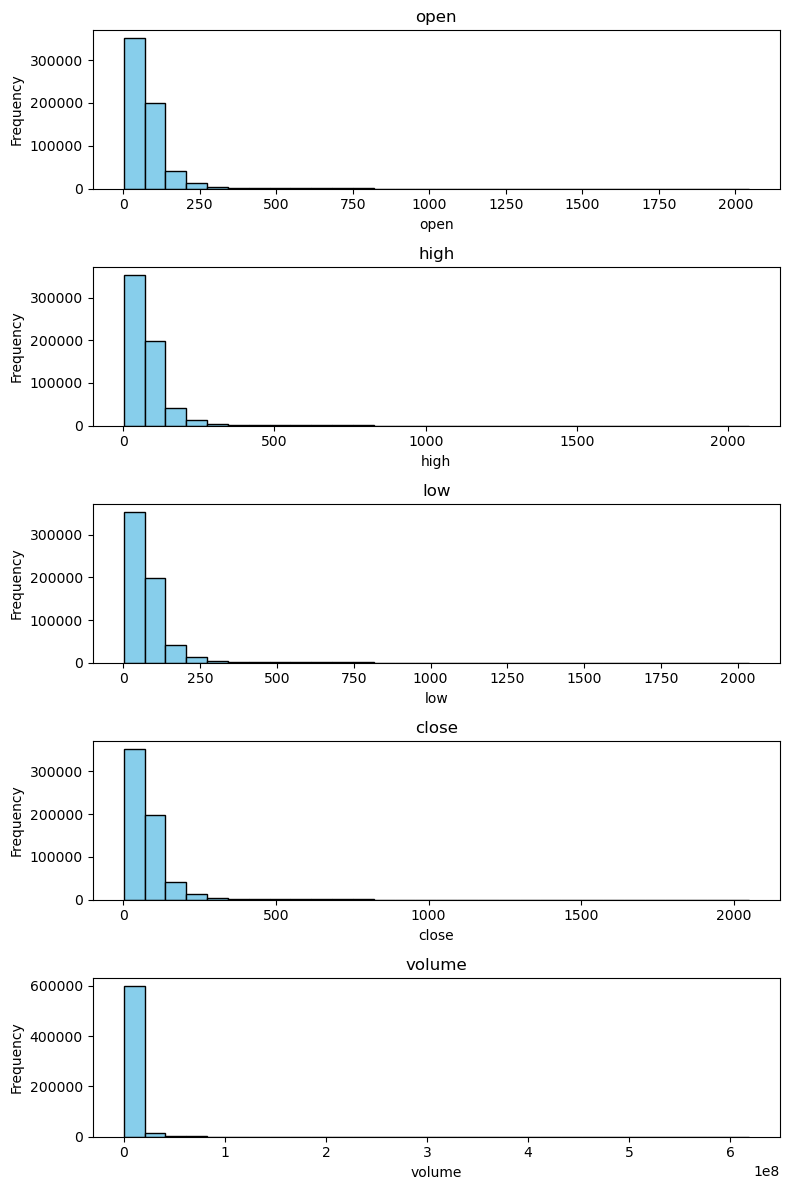

In [12]:
numerical_columns = ['open', 'high', 'low', 'close',  'volume']
# Plot histograms for the numerical columns
fig, axes = plt.subplots(nrows=len(numerical_columns), figsize=(8, 12))

for i, col in enumerate(numerical_columns):
    axes[i].hist(df_filled[col], bins=30, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

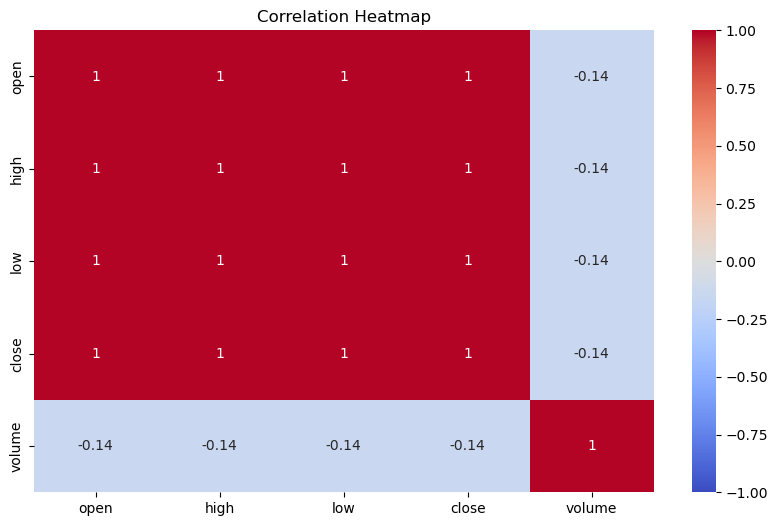

In [13]:
# Calculate the correlation matrix
corr_matrix = df_filled[numerical_columns].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Heatmap')
plt.show()

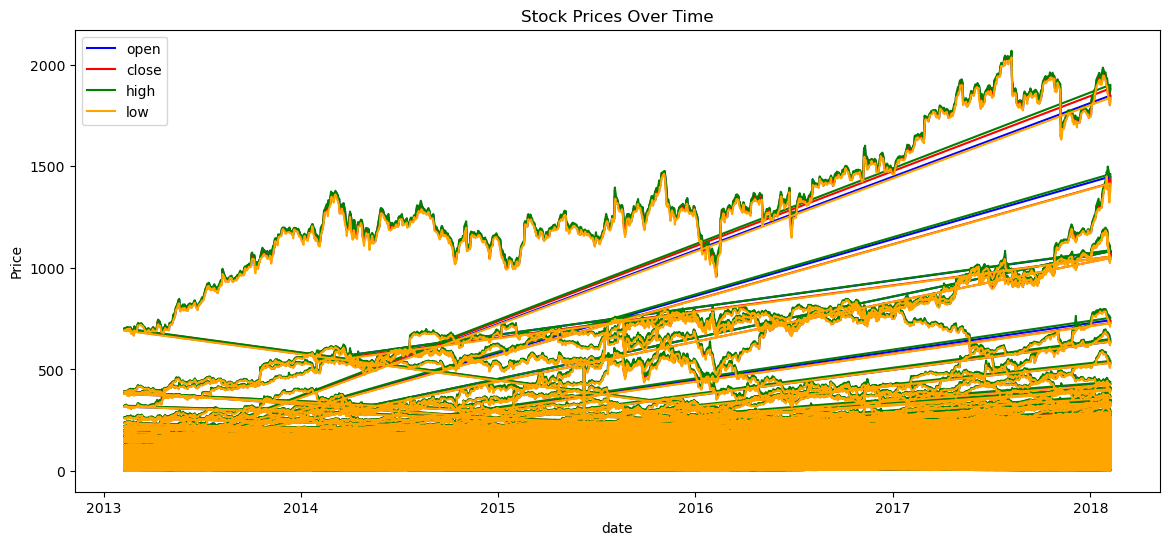

In [14]:
# Plot the 'Open', 'Close', 'High', and 'Low' prices over time
plt.figure(figsize=(14, 6))
plt.plot(df_filled['date'], df_filled['open'], label='open', color='blue')
plt.plot(df_filled['date'], df_filled['close'], label='close', color='red')
plt.plot(df_filled['date'], df_filled['high'], label='high', color='green')
plt.plot(df_filled['date'], df_filled['low'], label='low', color='orange')
plt.xlabel('date')
plt.ylabel('Price')
plt.title('Stock Prices Over Time')
plt.legend()
plt.show()

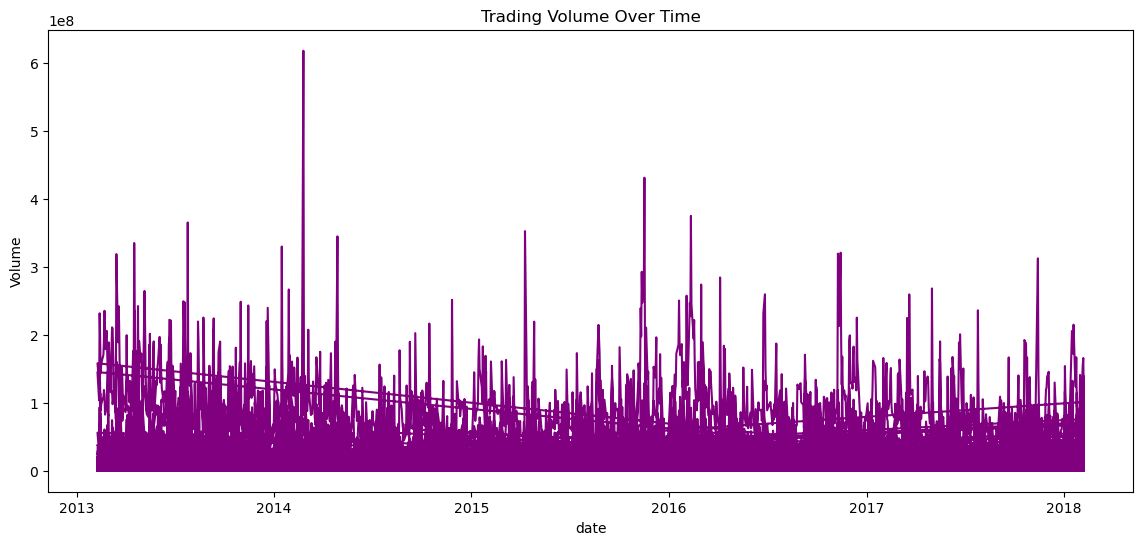

In [15]:
# Plot the 'Volume' of the stock over time
plt.figure(figsize=(14, 6))
plt.plot(df_filled['date'], df_filled['volume'], color='purple')
plt.xlabel('date')
plt.ylabel('Volume')
plt.title('Trading Volume Over Time')
plt.show()

# Data Processing for News Headlines

In [2]:
# Load the data
news_df = pd.read_csv('stock_news_headlines.csv')

news_df

Unnamed: 0                                           headline  \
0                 2  Agilent Technologies Announces Pricing of $5……...   
1                 3  Agilent (A) Gears Up for Q2 Earnings: What's i...   
2                 4  J.P. Morgan Asset Management Announces Liquida...   
3                 5  Pershing Square Capital Management, L.P. Buys ...   
4                 6  Agilent Awards Trilogy Sciences with a Golden ...   
...             ...                                                ...   
1845554     1849874                      Consumer Cyclical Sector Wrap   
1845555     1849875                      Consumer Cyclical Sector Wrap   
1845556     1849876  Zacks #5 Rank Additions for Monday - Tale of t...   
1845557     1849877  4 Stock Strategies From Wall Street: Feb. 9 (U...   
1845558     1849878        4 Stock Strategies From Wall Street: Feb. 9   

                                                       url      publisher  \
0        http://www.gurufocus.com/news/1153187/agilent-...      GuruFocus   
1        http://www.zacks.com/stock/news/931205/agilent...          Zacks   
2        http://www.gurufocus.com/news/1138923/jp-morga...      GuruFocus   
3        http://www.gurufocus.com/news/1138704/pershing...      GuruFocus   
4        http://www.gurufocus.com/news/1134012/agilent-...      GuruFocus   
...                                                    ...            ...   
1845554  https://www.benzinga.com/content/12/08/2846030...      webmaster   
1845555  https://www.benzinga.com/content/12/07/2767124...      webmaster   
1845556  http://www.zacks.com/stock/news/73497/here-are...          Zacks   
1845557  http://www.thestreet.com/story/11409053/1/4-st...  TheStreet.Com   
1845558  https://www.benzinga.com/content/thestreet-com...      webmaster   

                        date stock  
0        2020-06-01 00:00:00     A  
1        2020-05-18 00:00:00     A  
2        2020-05-15 00:00:00     A  
3        2020-05-15 00:00:00     A  
4        2020-05-12 00:00:00     A  
...                      ...   ...  
1845554  2012-08-20 00:00:00    ZX  
1845555  2012-07-23 00:00:00    ZX  
1845556  2012-04-23 00:00:00    ZX  
1845557  2012-02-09 00:00:00    ZX  
1845558  2012-02-09 00:00:00    ZX  

[1845559 rows x 6 columns]

In [3]:
# Check for missing values
missing_values = news_df.isnull().sum()
missing_values

Unnamed: 0    0
headline      0
url           0
publisher     0
date          0
stock         0
dtype: int64

In [17]:
# Dropping unnecessary column
news_df.drop(['Unnamed: 0'], axis=1, inplace=True)

In [18]:
news_df

headline  \
0        Agilent Technologies Announces Pricing of $5……...   
1        Agilent (A) Gears Up for Q2 Earnings: What's i...   
2        J.P. Morgan Asset Management Announces Liquida...   
3        Pershing Square Capital Management, L.P. Buys ...   
4        Agilent Awards Trilogy Sciences with a Golden ...   
...                                                    ...   
1845554                      Consumer Cyclical Sector Wrap   
1845555                      Consumer Cyclical Sector Wrap   
1845556  Zacks #5 Rank Additions for Monday - Tale of t...   
1845557  4 Stock Strategies From Wall Street: Feb. 9 (U...   
1845558        4 Stock Strategies From Wall Street: Feb. 9   

                                                       url      publisher  \
0        http://www.gurufocus.com/news/1153187/agilent-...      GuruFocus   
1        http://www.zacks.com/stock/news/931205/agilent...          Zacks   
2        http://www.gurufocus.com/news/1138923/jp-morga...      GuruFocus   
3        http://www.gurufocus.com/news/1138704/pershing...      GuruFocus   
4        http://www.gurufocus.com/news/1134012/agilent-...      GuruFocus   
...                                                    ...            ...   
1845554  https://www.benzinga.com/content/12/08/2846030...      webmaster   
1845555  https://www.benzinga.com/content/12/07/2767124...      webmaster   
1845556  http://www.zacks.com/stock/news/73497/here-are...          Zacks   
1845557  http://www.thestreet.com/story/11409053/1/4-st...  TheStreet.Com   
1845558  https://www.benzinga.com/content/thestreet-com...      webmaster   

                        date stock  
0        2020-06-01 00:00:00     A  
1        2020-05-18 00:00:00     A  
2        2020-05-15 00:00:00     A  
3        2020-05-15 00:00:00     A  
4        2020-05-12 00:00:00     A  
...                      ...   ...  
1845554  2012-08-20 00:00:00    ZX  
1845555  2012-07-23 00:00:00    ZX  
1845556  2012-04-23 00:00:00    ZX  
1845557  2012-02-09 00:00:00    ZX  
1845558  2012-02-09 00:00:00    ZX  

[1845559 rows x 5 columns]

In [19]:
# Convert the date column to a datetime format
news_df['date'] = pd.to_datetime(news_df['date'], errors='coerce')

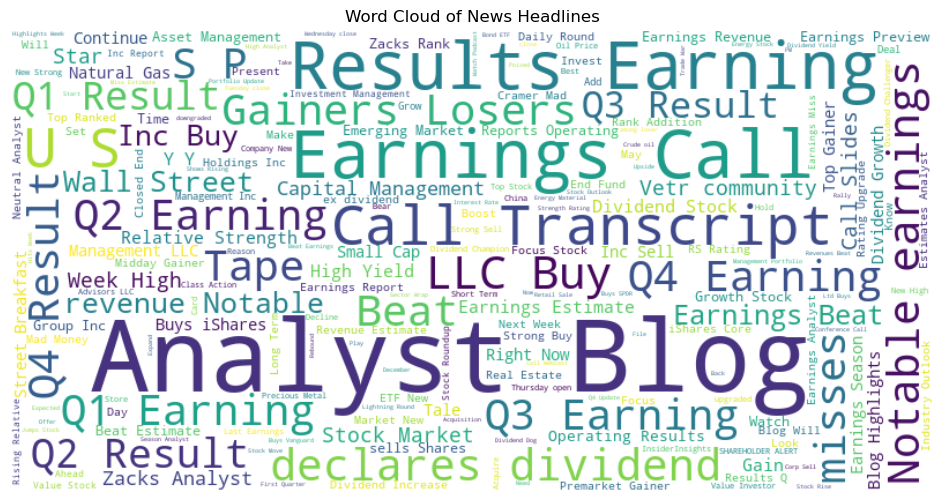

In [20]:
# Generate a word cloud for the headlines
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(news_df['headline']))
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Headlines')
plt.show()

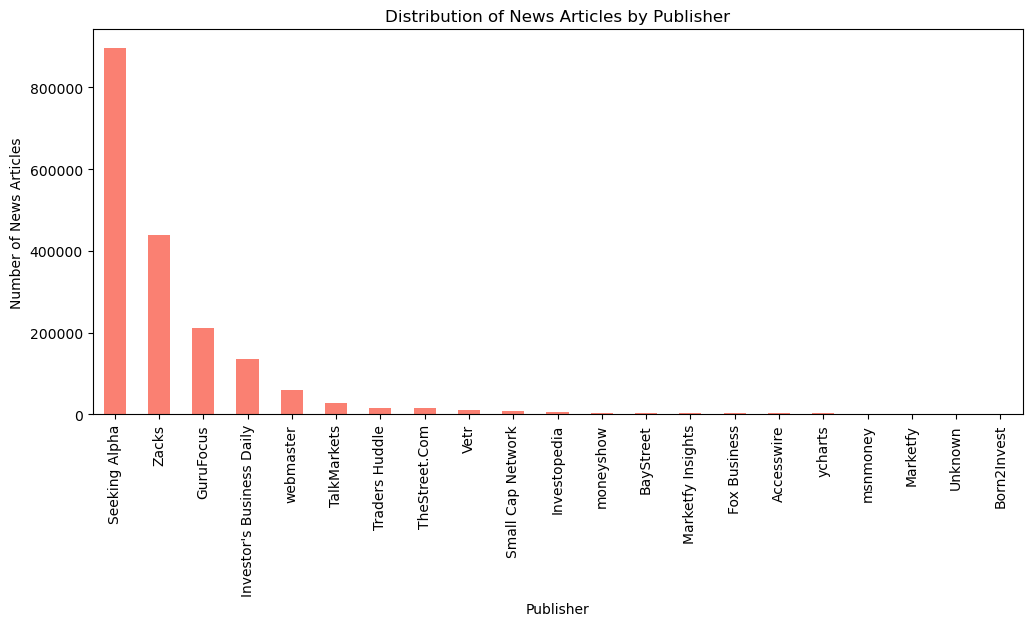

In [21]:
# Check the sources of the news articles
plt.figure(figsize=(12, 5))
news_df['publisher'].value_counts().plot(kind='bar', color='salmon')
plt.xlabel('Publisher')
plt.ylabel('Number of News Articles')
plt.title('Distribution of News Articles by Publisher')
plt.show()

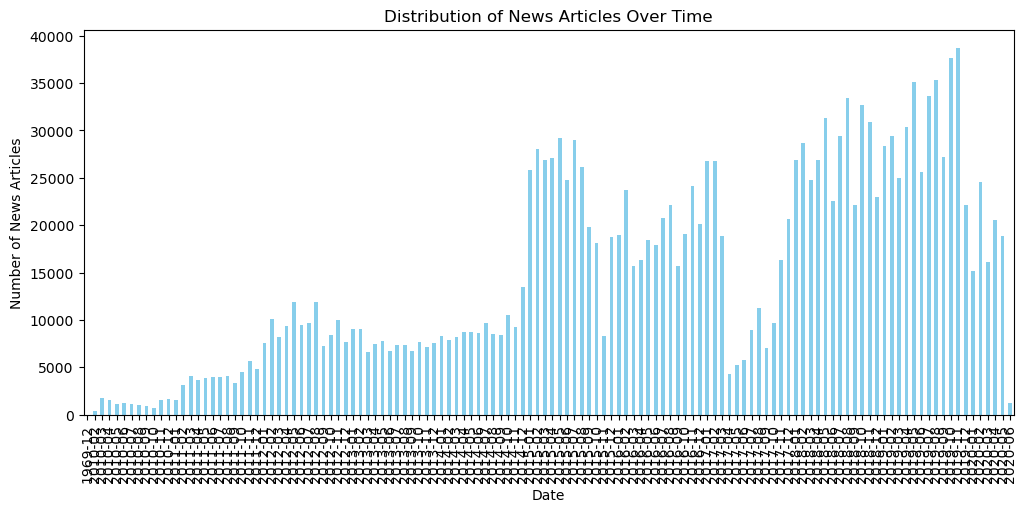

In [22]:
# Check the distribution of news articles over time
plt.figure(figsize=(12, 5))
news_df['date'].dt.to_period("M").value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Date')
plt.ylabel('Number of News Articles')
plt.title('Distribution of News Articles Over Time')
plt.show()

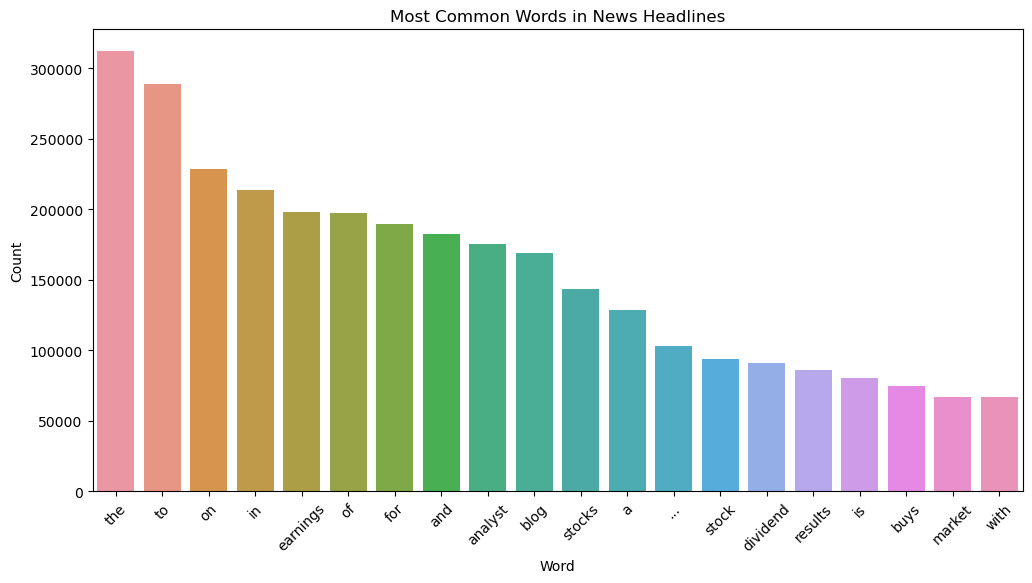

In [23]:
import string
# Tokenize the headlines using a simple approach (split by space)
headlines = news_df['headline'].str.lower()
tokens = headlines.str.split(expand=True).stack()

# Convert string.punctuation to a list for proper filtering
punctuation_list = list(string.punctuation)
filtered_tokens = tokens[~tokens.isin(punctuation_list)]
word_counts = Counter(filtered_tokens)

# Display the 20 most common words in the headlines
common_words = word_counts.most_common(20)
common_words_df = pd.DataFrame(common_words, columns=['Word', 'Count'])

# Plot the most common words in the headlines
plt.figure(figsize=(12, 6))
sns.barplot(x='Word', y='Count', data=common_words_df)
plt.xticks(rotation=45)
plt.xlabel('Word')
plt.ylabel('Count')
plt.title('Most Common Words in News Headlines')
plt.show()

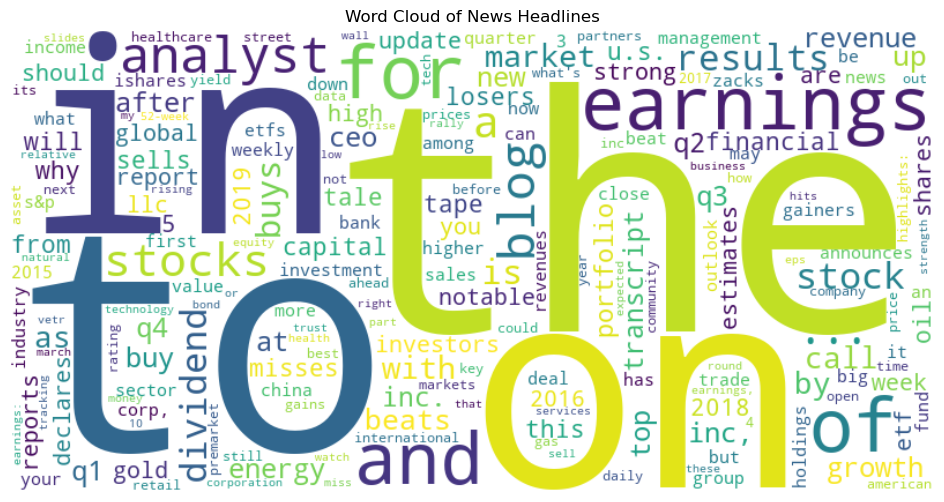

In [24]:
# Generate the word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_counts)

# Plot the word cloud
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of News Headlines')
plt.show()

In [25]:
news_df

headline  \
0        Agilent Technologies Announces Pricing of $5……...   
1        Agilent (A) Gears Up for Q2 Earnings: What's i...   
2        J.P. Morgan Asset Management Announces Liquida...   
3        Pershing Square Capital Management, L.P. Buys ...   
4        Agilent Awards Trilogy Sciences with a Golden ...   
...                                                    ...   
1845554                      Consumer Cyclical Sector Wrap   
1845555                      Consumer Cyclical Sector Wrap   
1845556  Zacks #5 Rank Additions for Monday - Tale of t...   
1845557  4 Stock Strategies From Wall Street: Feb. 9 (U...   
1845558        4 Stock Strategies From Wall Street: Feb. 9   

                                                       url      publisher  \
0        http://www.gurufocus.com/news/1153187/agilent-...      GuruFocus   
1        http://www.zacks.com/stock/news/931205/agilent...          Zacks   
2        http://www.gurufocus.com/news/1138923/jp-morga...      GuruFocus   
3        http://www.gurufocus.com/news/1138704/pershing...      GuruFocus   
4        http://www.gurufocus.com/news/1134012/agilent-...      GuruFocus   
...                                                    ...            ...   
1845554  https://www.benzinga.com/content/12/08/2846030...      webmaster   
1845555  https://www.benzinga.com/content/12/07/2767124...      webmaster   
1845556  http://www.zacks.com/stock/news/73497/here-are...          Zacks   
1845557  http://www.thestreet.com/story/11409053/1/4-st...  TheStreet.Com   
1845558  https://www.benzinga.com/content/thestreet-com...      webmaster   

              date stock  
0       2020-06-01     A  
1       2020-05-18     A  
2       2020-05-15     A  
3       2020-05-15     A  
4       2020-05-12     A  
...            ...   ...  
1845554 2012-08-20    ZX  
1845555 2012-07-23    ZX  
1845556 2012-04-23    ZX  
1845557 2012-02-09    ZX  
1845558 2012-02-09    ZX  

[1845559 rows x 5 columns]

# Vader Sentiment

In [26]:
# Download the VADER lexicon
nltk.download('vader_lexicon')

# Initialize the VADER Sentiment Analyzer
sid = SentimentIntensityAnalyzer()

# Apply VADER on the 'headline' column and create a new column to store the polarity scores
news_df['vader_sentiment'] = news_df['headline'].apply(lambda x: sid.polarity_scores(x))

# Display the DataFrame with the VADER sentiment scores
news_df

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\nayee\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


headline  \
0        Agilent Technologies Announces Pricing of $5……...   
1        Agilent (A) Gears Up for Q2 Earnings: What's i...   
2        J.P. Morgan Asset Management Announces Liquida...   
3        Pershing Square Capital Management, L.P. Buys ...   
4        Agilent Awards Trilogy Sciences with a Golden ...   
...                                                    ...   
1845554                      Consumer Cyclical Sector Wrap   
1845555                      Consumer Cyclical Sector Wrap   
1845556  Zacks #5 Rank Additions for Monday - Tale of t...   
1845557  4 Stock Strategies From Wall Street: Feb. 9 (U...   
1845558        4 Stock Strategies From Wall Street: Feb. 9   

                                                       url      publisher  \
0        http://www.gurufocus.com/news/1153187/agilent-...      GuruFocus   
1        http://www.zacks.com/stock/news/931205/agilent...          Zacks   
2        http://www.gurufocus.com/news/1138923/jp-morga...      GuruFocus   
3        http://www.gurufocus.com/news/1138704/pershing...      GuruFocus   
4        http://www.gurufocus.com/news/1134012/agilent-...      GuruFocus   
...                                                    ...            ...   
1845554  https://www.benzinga.com/content/12/08/2846030...      webmaster   
1845555  https://www.benzinga.com/content/12/07/2767124...      webmaster   
1845556  http://www.zacks.com/stock/news/73497/here-are...          Zacks   
1845557  http://www.thestreet.com/story/11409053/1/4-st...  TheStreet.Com   
1845558  https://www.benzinga.com/content/thestreet-com...      webmaster   

              date stock                                    vader_sentiment  
0       2020-06-01     A  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1       2020-05-18     A  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
2       2020-05-15     A  {'neg': 0.0, 'neu': 0.783, 'pos': 0.217, 'comp...  
3       2020-05-15     A  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
4       2020-05-12     A  {'neg': 0.0, 'neu': 0.727, 'pos': 0.273, 'comp...  
...            ...   ...                                                ...  
1845554 2012-08-20    ZX  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1845555 2012-07-23    ZX  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1845556 2012-04-23    ZX  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1845557 2012-02-09    ZX  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  
1845558 2012-02-09    ZX  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...  

[1845559 rows x 6 columns]

In [27]:
news_df['vader_negative'] = news_df['vader_sentiment'].apply(lambda x: x['neg'])
news_df['vader_neutral'] = news_df['vader_sentiment'].apply(lambda x: x['neu'])
news_df['vader_positive'] = news_df['vader_sentiment'].apply(lambda x: x['pos'])
news_df['vader_compound'] = news_df['vader_sentiment'].apply(lambda x: x['compound'])

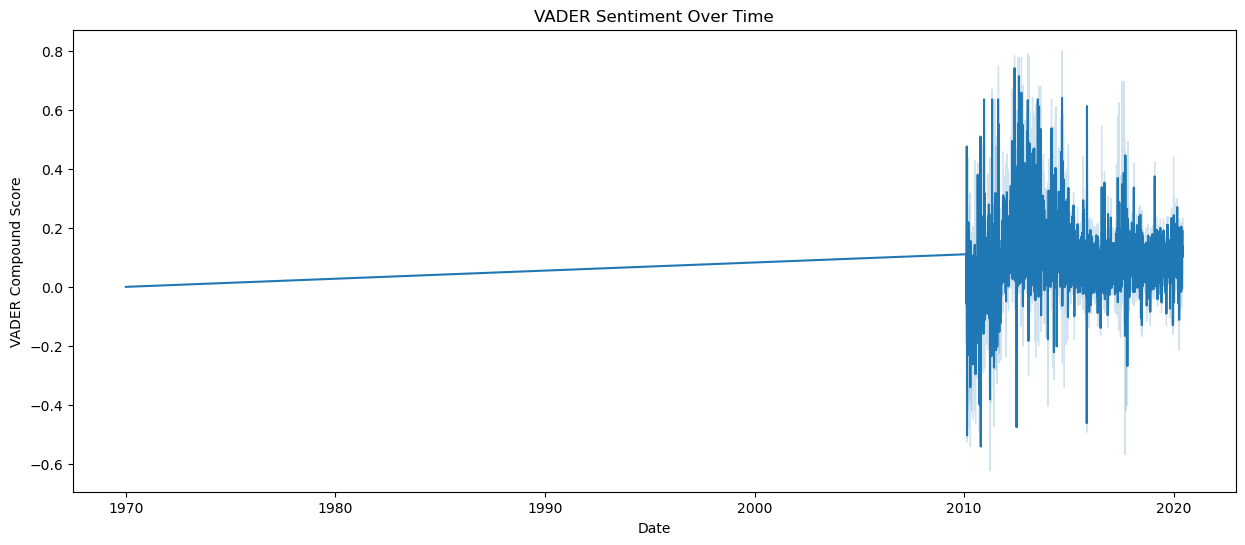

In [28]:
# Create a time-series plot for sentiment
plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='vader_compound', data=news_df)
plt.title('VADER Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('VADER Compound Score')
plt.show()

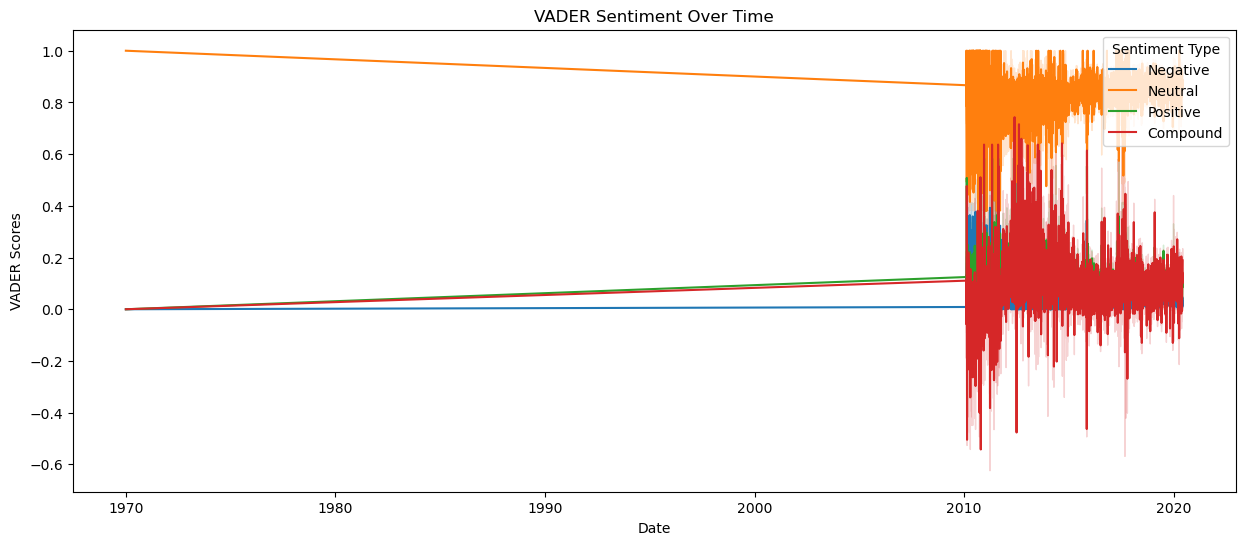

In [29]:
# Sort DataFrame by date
news_df = news_df.sort_values('date')

# Create a time-series plot for sentiment
plt.figure(figsize=(15, 6))

sns.lineplot(x='date', y='vader_negative', data=news_df, label='Negative')
sns.lineplot(x='date', y='vader_neutral', data=news_df, label='Neutral')
sns.lineplot(x='date', y='vader_positive', data=news_df, label='Positive')
sns.lineplot(x='date', y='vader_compound', data=news_df, label='Compound')

plt.title('VADER Sentiment Over Time')
plt.xlabel('Date')
plt.ylabel('VADER Scores')
plt.legend(title='Sentiment Type', loc='upper right')
plt.show()

# LDA Sentiment

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Initialize CountVectorizer
vectorizer = CountVectorizer(max_df=0.9, min_df=25, stop_words='english')
dtm = vectorizer.fit_transform(news_df['headline'])

# Apply LDA
lda = LatentDirichletAllocation(n_components=3, random_state=42)
lda.fit(dtm)

# Assign topic to each headline
topic_results = lda.transform(dtm)
news_df['lda_topic'] = topic_results.argmax(axis=1)

In [34]:
# Preprocess the text data
def preprocess(text):
    tokens = word_tokenize(text.lower())
    tokens = [token for token in tokens if token not in string.punctuation]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return tokens

# Tokenize and preprocess the text data
news_df['tokens'] = news_df['headline'].apply(preprocess)

# Create a dictionary and corpus for LDA
dictionary = corpora.Dictionary(news_df['tokens'])
corpus = [dictionary.doc2bow(tokens) for tokens in news_df['tokens']]

# Perform LDA
num_topics = 3
lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)

# Display the topics
topics = lda_model.print_topics(num_words=5)
for topic in topics:
    print(topic)

(0, '0.051*"earnings" + 0.021*"\'s" + 0.019*"q1" + 0.016*"estimates" + 0.010*"q4"')
(1, '0.073*"..." + 0.049*"buys" + 0.048*"inc" + 0.022*"llc" + 0.020*"corp"')
(2, '0.044*"market" + 0.038*"stocks" + 0.033*"stock" + 0.020*"top" + 0.017*"growth"')


In [35]:
news_df

headline  \
1096135  Montpelier Re Holdings Ltd. (MRH): New Analyst...   
469572                   The Bears Are Running Out of Ammo   
1164028             Looking for Logic in the Market Action   
1087697                Fitz Bits: Broadcom Shooting Higher   
1569734               Storm Brewing in Chinese Real Estate   
...                                                    ...   
921241   Saba Capital Management, L.P. Buys Voya Prime ...   
1150488  Natural Grocers Opens In Cedar City On June –…...   
1229338                      Dow Surges 2% and Retakes 26K   
1003815  5 High-Flying Corporate Behemoths With More Up...   
1445027  Robbins Geller Rudman & Dowd LLP Files Class A...   

                                                       url  publisher  \
1096135  http://www.zacks.com/stock/research/MRH/equity...      Zacks   
469572   https://www.benzinga.com/content/thestreet-com...  webmaster   
1164028  https://www.benzinga.com/content/thestreet-com...  webmaster   
1087697  https://www.benzinga.com/content/thestreet-com...  webmaster   
1569734  https://www.benzinga.com/content/thestreet-com...  webmaster   
...                                                    ...        ...   
921241   http://www.gurufocus.com/news/1155680/saba-cap...  GuruFocus   
1150488  http://www.gurufocus.com/news/1155357/natural-...  GuruFocus   
1229338  https://www.zacks.com/registration/ultimatetra...      Zacks   
1003815  http://www.zacks.com/stock/news/962801/5-high-...      Zacks   
1445027  http://www.gurufocus.com/news/1155172/robbins-...  GuruFocus   

              date stock                                    vader_sentiment  \
1096135 1969-12-31   MRH  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
469572  2010-02-03   DTV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1164028 2010-02-03   NOV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1087697 2010-02-03   MOO  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1569734 2010-02-03   TAO  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
...            ...   ...                                                ...   
921241  2020-06-04   JRO  {'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...   
1150488 2020-06-04  NGVC  {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...   
1229338 2020-06-04   OXM  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1003815 2020-06-04   LOW  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1445027 2020-06-04  SERV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

         vader_negative  vader_neutral  vader_positive  vader_compound  \
1096135             0.0          1.000           0.000          0.0000   
469572              0.0          1.000           0.000          0.0000   
1164028             0.0          1.000           0.000          0.0000   
1087697             0.0          1.000           0.000          0.0000   
1569734             0.0          1.000           0.000          0.0000   
...                 ...            ...             ...             ...   
921241              0.0          0.809           0.191          0.5106   
1150488             0.0          0.857           0.143          0.3612   
1229338             0.0          1.000           0.000          0.0000   
1003815             0.0          1.000           0.000          0.0000   
1445027             0.0          1.000           0.000          0.0000   

         lda_topic                                             tokens  
1096135          2  [montpelier, holdings, ltd., mrh, new, analyst...  
469572           1                             [bears, running, ammo]  
1164028          1                   [looking, logic, market, action]  
1087697          1           [fitz, bits, broadcom, shooting, higher]  
1569734          0            [storm, brewing, chinese, real, estate]  
...            ...                                                ...  
921241           0  [saba, capital, management, l.p., buys, voya, ...  
1150488       

In [31]:
# Aggregate by date
agg_df = news_df.groupby('date').agg({
    'vader_negative': 'mean',
    'vader_neutral': 'mean',
    'vader_positive': 'mean',
    'vader_compound': 'mean',
    'lda_topic': lambda x: x.value_counts().index[0]  # Most frequent topic
}).reset_index()


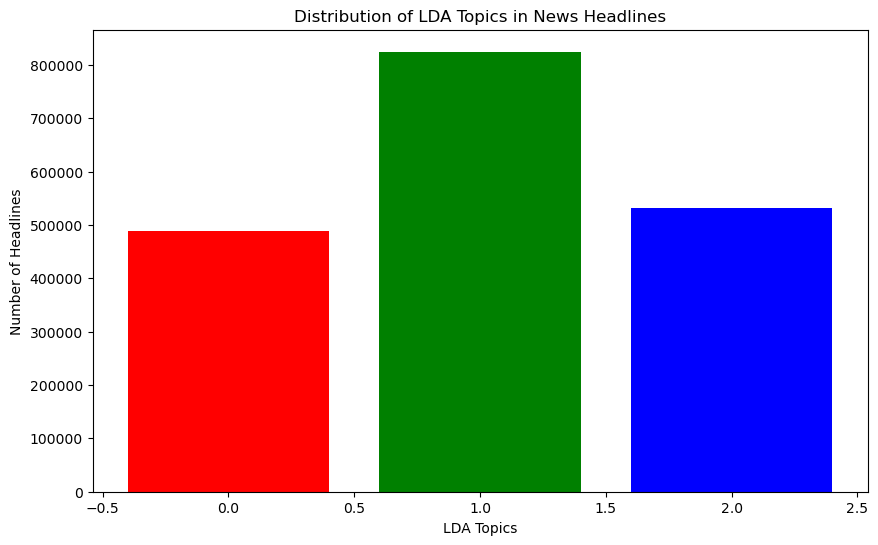

In [32]:
# Count the number of headlines for each topic
topic_counts = news_df['lda_topic'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(topic_counts.index, topic_counts.values, color=['red', 'green', 'blue'])

# Add labels and title
plt.xlabel('LDA Topics')
plt.ylabel('Number of Headlines')
plt.title('Distribution of LDA Topics in News Headlines')

# Show the plot
plt.show()

# Bag-of-Words Sentiment Analysis

In [53]:
from textblob import TextBlob

def calculate_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return 'positive'
    elif analysis.sentiment.polarity == 0:
        return 'neutral'
    else:
        return 'negative'

news_df['bag_of_words_sentiment'] = news_df['headline'].apply(calculate_sentiment)

In [54]:
news_df

headline  \
1096135  Montpelier Re Holdings Ltd. (MRH): New Analyst...   
469572                   The Bears Are Running Out of Ammo   
1164028             Looking for Logic in the Market Action   
1087697                Fitz Bits: Broadcom Shooting Higher   
1569734               Storm Brewing in Chinese Real Estate   
...                                                    ...   
921241   Saba Capital Management, L.P. Buys Voya Prime ...   
1150488  Natural Grocers Opens In Cedar City On June –…...   
1229338                      Dow Surges 2% and Retakes 26K   
1003815  5 High-Flying Corporate Behemoths With More Up...   
1445027  Robbins Geller Rudman & Dowd LLP Files Class A...   

                                                       url  publisher  \
1096135  http://www.zacks.com/stock/research/MRH/equity...      Zacks   
469572   https://www.benzinga.com/content/thestreet-com...  webmaster   
1164028  https://www.benzinga.com/content/thestreet-com...  webmaster   
1087697  https://www.benzinga.com/content/thestreet-com...  webmaster   
1569734  https://www.benzinga.com/content/thestreet-com...  webmaster   
...                                                    ...        ...   
921241   http://www.gurufocus.com/news/1155680/saba-cap...  GuruFocus   
1150488  http://www.gurufocus.com/news/1155357/natural-...  GuruFocus   
1229338  https://www.zacks.com/registration/ultimatetra...      Zacks   
1003815  http://www.zacks.com/stock/news/962801/5-high-...      Zacks   
1445027  http://www.gurufocus.com/news/1155172/robbins-...  GuruFocus   

              date stock                                    vader_sentiment  \
1096135 1969-12-31   MRH  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
469572  2010-02-03   DTV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1164028 2010-02-03   NOV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1087697 2010-02-03   MOO  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1569734 2010-02-03   TAO  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
...            ...   ...                                                ...   
921241  2020-06-04   JRO  {'neg': 0.0, 'neu': 0.809, 'pos': 0.191, 'comp...   
1150488 2020-06-04  NGVC  {'neg': 0.0, 'neu': 0.857, 'pos': 0.143, 'comp...   
1229338 2020-06-04   OXM  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1003815 2020-06-04   LOW  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   
1445027 2020-06-04  SERV  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...   

         vader_negative  vader_neutral  vader_positive  vader_compound  \
1096135             0.0          1.000           0.000          0.0000   
469572              0.0          1.000           0.000          0.0000   
1164028             0.0          1.000           0.000          0.0000   
1087697             0.0          1.000           0.000          0.0000   
1569734             0.0          1.000           0.000          0.0000   
...                 ...            ...             ...             ...   
921241              0.0          0.809           0.191          0.5106   
1150488             0.0          0.857           0.143          0.3612   
1229338             0.0          1.000           0.000          0.0000   
1003815             0.0          1.000           0.000          0.0000   
1445027             0.0          1.000           0.000          0.0000   

         lda_topic bag_of_words_sentiment  
1096135          2               positive  
469572           1                neutral  
1164028          1               positive  
1087697          1               positive  
1569734          0               positive  
...            ...                    ...  
921241           0                neutral  
1150488          1                neutral  
1229338          1                neutral  
1003815          1               positive  
1445027          0               positive  

[1845559 rows x 12 columns]

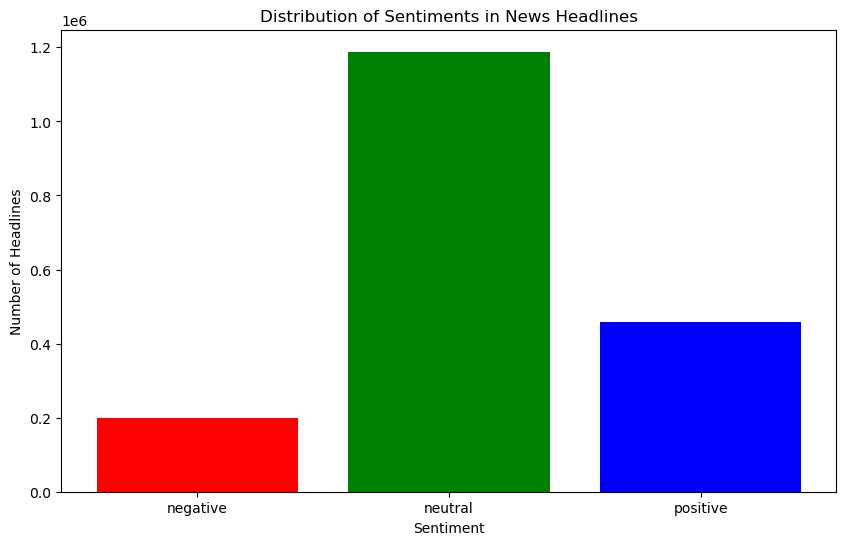

In [55]:
# Count the number of headlines for each sentiment
sentiment_counts = news_df['bag_of_words_sentiment'].value_counts().sort_index()

# Create a bar chart
plt.figure(figsize=(10, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values, color=['red', 'green', 'blue'])

# Add labels and title
plt.xlabel('Sentiment')
plt.ylabel('Number of Headlines')
plt.title('Distribution of Sentiments in News Headlines')

# Show the plot
plt.show()

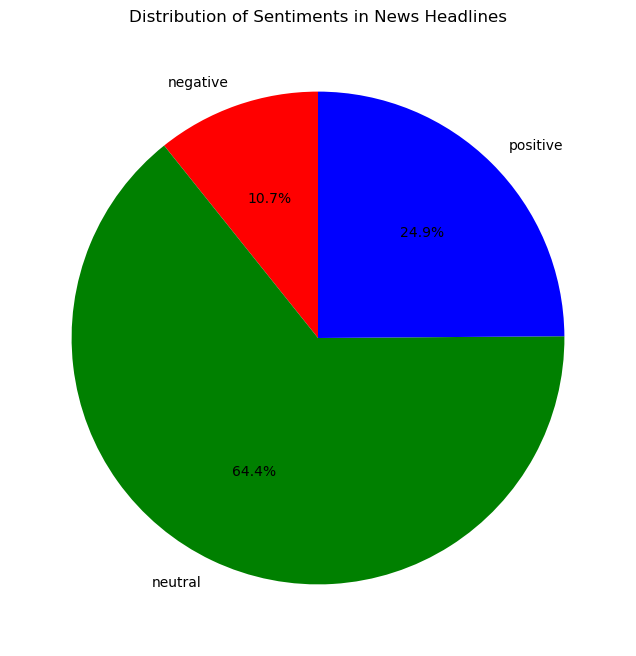

In [56]:
# Create a pie chart
plt.figure(figsize=(8, 8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['red', 'green', 'blue'])

# Add title
plt.title('Distribution of Sentiments in News Headlines')

# Show the plot
plt.show()

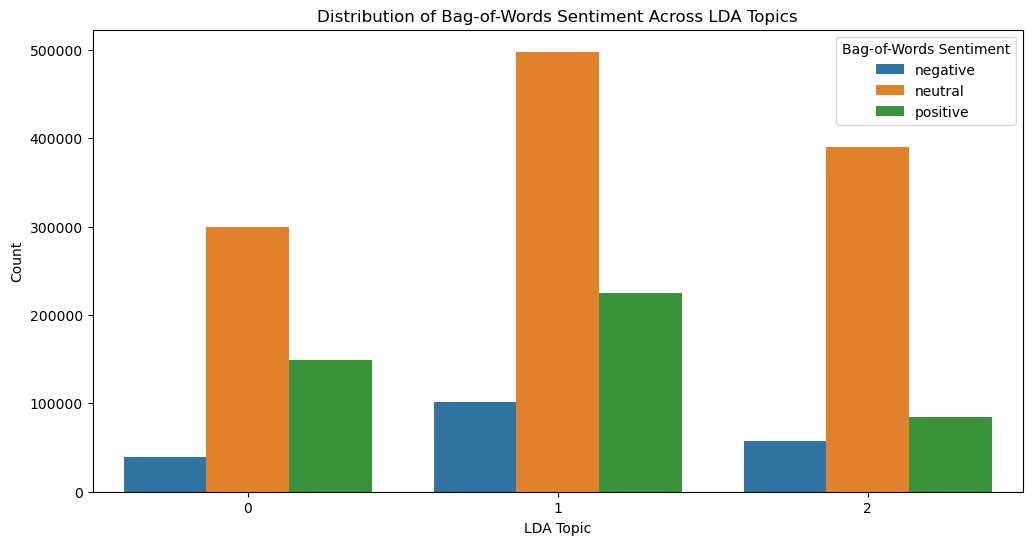

In [57]:
grouped_data = news_df.groupby(['lda_topic', 'bag_of_words_sentiment']).size().reset_index(name='count')

# Create the plot
plt.figure(figsize=(12, 6))
sns.barplot(x='lda_topic', y='count', hue='bag_of_words_sentiment', data=grouped_data)

plt.title('Distribution of Bag-of-Words Sentiment Across LDA Topics')
plt.xlabel('LDA Topic')
plt.ylabel('Count')
plt.legend(title='Bag-of-Words Sentiment')

plt.show()

# Merging Datasets

In [58]:
merged_df = pd.merge(df_filled, agg_df, on='date', how='inner')

In [59]:
merged_df

date      open      high       low     close     volume stock  \
0      2013-02-08   15.0700   15.1200   14.6300   14.7500    8407500   AAL   
1      2013-02-08   67.7142   68.4014   66.8928   67.8542  158168416  AAPL   
2      2013-02-08   78.3400   79.7200   78.0100   78.9000    1298137   AAP   
3      2013-02-08   36.3700   36.4200   35.8250   36.2500   13858795  ABBV   
4      2013-02-08   46.5200   46.8950   46.4600   46.8900    1232802   ABC   
...           ...       ...       ...       ...       ...        ...   ...   
615083 2018-02-07   71.2700   72.8600   71.1200   71.7900    1748941   XYL   
615084 2018-02-07   80.0700   81.9400   80.0000   80.1300    3561068   YUM   
615085 2018-02-07  121.6500  123.5200  120.7400  120.7800    1145267   ZBH   
615086 2018-02-07   52.2300   54.3150   52.2200   54.0200    6427280  ZION   
615087 2018-02-07   72.7000   75.0000   72.6900   73.8600    4534912   ZTS   

        vader_negative  vader_neutral  vader_positive  vader_compound  \
0             0.071634       0.851574        0.076806        0.002132   
1             0.071634       0.851574        0.076806        0.002132   
2             0.071634       0.851574        0.076806        0.002132   
3             0.071634       0.851574        0.076806        0.002132   
4             0.071634       0.851574        0.076806        0.002132   
...                ...            ...             ...             ...   
615083        0.053130       0.882863        0.064022        0.022404   
615084        0.053130       0.882863        0.064022        0.022404   
615085        0.053130       0.882863        0.064022        0.022404   
615086        0.053130       0.882863        0.064022        0.022404   
615087        0.053130       0.882863        0.064022        0.022404   

        lda_topic  
0               2  
1               2  
2               2  
3               2  
4               2  
...           ...  
615083          0  
615084          0  
615085          0  
615086          0  
615087          0  

[615088 rows x 12 columns]

In [60]:
merged_df.isna().sum()

date              0
open              0
high              0
low               0
close             0
volume            0
stock             0
vader_negative    0
vader_neutral     0
vader_positive    0
vader_compound    0
lda_topic         0
dtype: int64

# Prediction Model

In [83]:
from sklearn.model_selection import train_test_split
features = ['open', 'high', 'low', 'volume', 'vader_negative', 'vader_neutral', 'vader_positive', 'vader_compound', 'lda_topic']
target = 'close'

# Prepare the features and target variable
X = merged_df[features].values
y = merged_df[target].values
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Reshape X to be (number_of_samples, 1, 9)
X_reshaped = np.reshape(X_scaled, (X_scaled.shape[0], 1, X_scaled.shape[1]))

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42)

model = Sequential()
model.add(LSTM(50, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])
model.save('new_lstm_model.h5')

Epoch 1/100
12302/12302 [==============================] - 39s 3ms/step - loss: 7327.0972 - val_loss: 4139.0459
Epoch 2/100
12302/12302 [==============================] - 37s 3ms/step - loss: 3346.7192 - val_loss: 2352.9524
Epoch 3/100
12302/12302 [==============================] - 37s 3ms/step - loss: 2033.1471 - val_loss: 1477.7507
Epoch 4/100
12302/12302 [==============================] - 38s 3ms/step - loss: 1346.5693 - val_loss: 1000.2896
Epoch 5/100
12302/12302 [==============================] - 38s 3ms/step - loss: 955.6912 - val_loss: 715.3154
Epoch 6/100
12302/12302 [==============================] - 41s 3ms/step - loss: 712.8894 - val_loss: 520.9841
Epoch 7/100
12302/12302 [==============================] - 44s 4ms/step - loss: 556.8558 - val_loss: 395.0456
Epoch 8/100
12302/12302 [==============================] - 37s 3ms/step - loss: 431.4836 - val_loss: 302.5987
Epoch 9/100
12302/12302 [==============================] - 38s 3ms/step - loss: 349.9355 - val_loss: 236.2681
Ep

C:\Users\nayee\anaconda3\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [84]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                12000     
                                                                 
 dropout_4 (Dropout)         (None, 50)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 51        
                                                                 
Total params: 12051 (47.07 KB)
Trainable params: 12051 (47.07 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [91]:
with open('feature_scaler.pkl', 'wb') as f:
    pickle.dump(feature_scaler, f)

print("MinMaxScaler has been saved as feature_scaler.pkl")

MinMaxScaler has been saved as feature_scaler.pkl


In [92]:
# After fitting the MinMaxScaler
feature_scaler = MinMaxScaler()
X_scaled = feature_scaler.fit_transform(X)

# Check the number of features
num_features = feature_scaler.n_features_in_

print(f"The number of features is: {num_features}")


The number of features is: 9


## RMSE

In [94]:
y_pred = model.predict(X_test)

# Reshape y_test and y_pred to be 1D arrays
y_test = np.reshape(y_test, (y_test.shape[0],))
y_pred = np.reshape(y_pred, (y_pred.shape[0],))

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Square Error (RMSE): {rmse}")

# If you want to see the predicted vs actual values
for i in range(len(y_test)):
    print(f"Actual: {y_test[i]}, Predicted: {y_pred[i]}")

3845/3845 [==============================] - 6s 1ms/step
Root Mean Square Error (RMSE): 2.795207545859875
Actual: 125.11, Predicted: 123.34471130371094
Actual: 181.51, Predicted: 185.28329467773438
Actual: 96.5, Predicted: 96.4144287109375
Actual: 36.74, Predicted: 35.83280944824219
Actual: 60.72, Predicted: 60.542236328125
Actual: 9.36, Predicted: 13.543022155761719
Actual: 85.69, Predicted: 85.45327758789062
Actual: 59.66, Predicted: 59.218074798583984
Actual: 51.78, Predicted: 51.532318115234375
Actual: 33.02, Predicted: 32.58479690551758
Actual: 113.22, Predicted: 112.83564758300781
Actual: 150.94, Predicted: 151.89608764648438
Actual: 159.83, Predicted: 161.49754333496094
Actual: 99.65, Predicted: 100.69075012207031
Actual: 72.31, Predicted: 72.68328094482422
Actual: 65.82, Predicted: 65.45015716552734
Actual: 72.36, Predicted: 72.21166229248047
Actual: 55.62, Predicted: 55.59507751464844
Actual: 94.87, Predicted: 94.37271881103516
Actual: 129.38, Predicted: 129.72705078125
Actual

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [95]:
X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))  # Reshape back to 2D
X_test_df = pd.DataFrame(feature_scaler.inverse_transform(X_test_reshaped), columns=features, index=X_test.index if isinstance(X_test, pd.DataFrame) else None)

X_test_df['Predicted_Close'] = y_pred

print(X_test_df)

          open     high      low      volume  vader_negative  vader_neutral  \
0       122.30  125.205  121.700    666841.0        0.061147       0.857196   
1       184.75  184.750  181.440    600635.0        0.028880       0.839700   
2        96.53   97.020   96.110   1880931.0        0.037624       0.844980   
3        36.85   37.230   36.670  44274987.0        0.013540       0.877682   
4        60.66   60.900   60.530   1395131.0        0.025180       0.841861   
...        ...      ...      ...         ...             ...            ...   
123013   62.63   63.140   62.514   1725339.0        0.063197       0.816552   
123014   75.97   76.030   74.650   1634335.0        0.060063       0.853914   
123015  165.12  165.740  162.090    799095.0        0.068852       0.885841   
123016   18.45   19.080   18.270   3968646.0        0.041852       0.846279   
123017  113.25  114.130  112.260  16128673.0        0.046396       0.842941   

        vader_positive  vader_compound  lda_topic  

In [97]:
from sklearn.metrics import mean_squared_error
from math import sqrt

# Generate predictions using the trained LSTM model
y_pred = model.predict(X_test)

# Reshape y_pred and y_test to be 1D arrays
y_pred = y_pred.flatten()
y_test = y_test.flatten()

# Calculate RMSE (Root Mean Squared Error)
rmse = sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

X_test_reshaped = np.reshape(X_test, (X_test.shape[0], X_test.shape[2]))  # Reshape back to 2D
X_test_df = pd.DataFrame(feature_scaler.inverse_transform(X_test_reshaped), columns=features)

X_test_df['Predicted_Close'] = y_pred

print(X_test_df)

3845/3845 [==============================] - 6s 1ms/step
Root Mean Squared Error (RMSE): 2.795207545859875
          open     high      low      volume  vader_negative  vader_neutral  \
0       122.30  125.205  121.700    666841.0        0.061147       0.857196   
1       184.75  184.750  181.440    600635.0        0.028880       0.839700   
2        96.53   97.020   96.110   1880931.0        0.037624       0.844980   
3        36.85   37.230   36.670  44274987.0        0.013540       0.877682   
4        60.66   60.900   60.530   1395131.0        0.025180       0.841861   
...        ...      ...      ...         ...             ...            ...   
123013   62.63   63.140   62.514   1725339.0        0.063197       0.816552   
123014   75.97   76.030   74.650   1634335.0        0.060063       0.853914   
123015  165.12  165.740  162.090    799095.0        0.068852       0.885841   
123016   18.45   19.080   18.270   3968646.0        0.041852       0.846279   
123017  113.25  114.130 

## Price Prediction

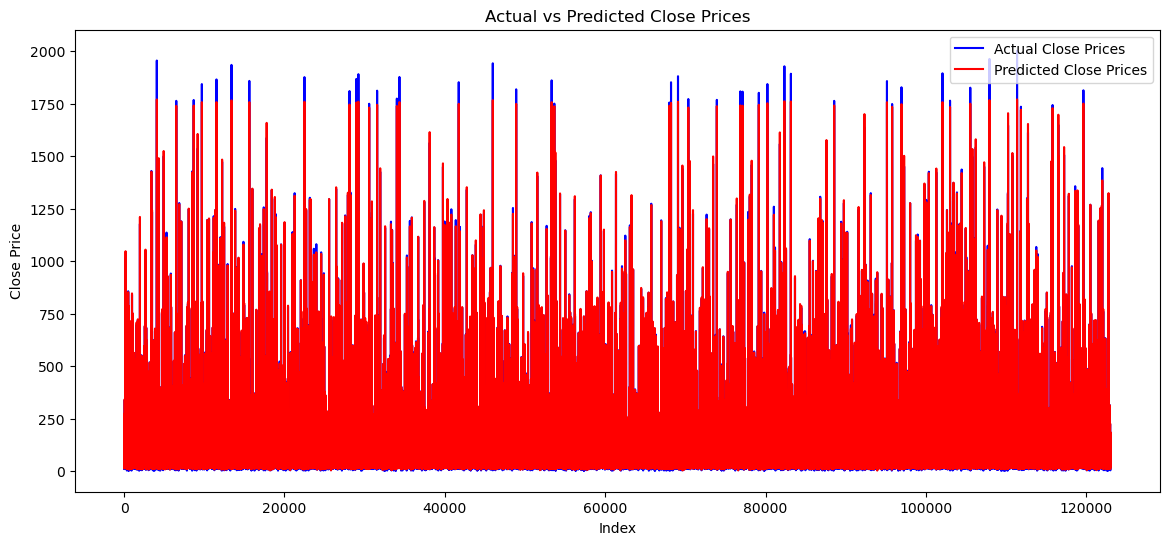

In [98]:
# Create a DataFrame for visualization
vis_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

# Plotting the actual vs predicted values
plt.figure(figsize=(14, 6))
plt.plot(vis_df['Actual'], label='Actual Close Prices', color='blue')
plt.plot(vis_df['Predicted'], label='Predicted Close Prices', color='red')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()

## Actual vs Predicted Prices for the Last 60 Days

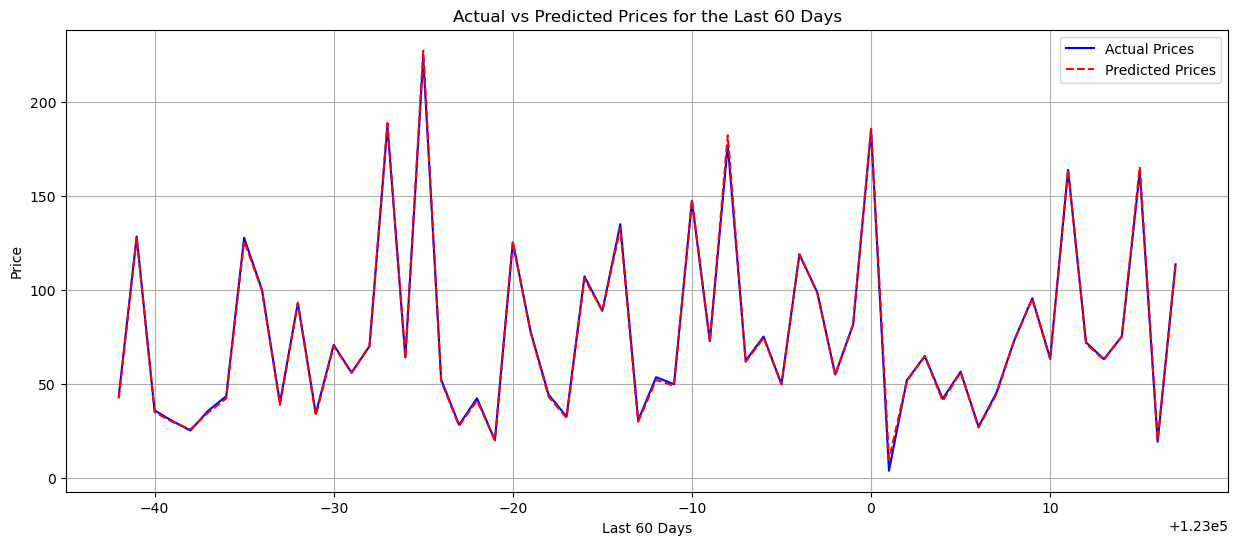

In [100]:
plot_df = pd.DataFrame({
    'Actual_Close': y_test,  
    'Predicted_Close': y_pred
})

# Plotting the last 60 days
plot_df_last_60_days = plot_df[-60:]

plt.figure(figsize=(15, 6))
plt.plot(plot_df_last_60_days['Actual_Close'], label='Actual Prices', color='blue')
plt.plot(plot_df_last_60_days['Predicted_Close'], label='Predicted Prices', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Prices for the Last 60 Days')
plt.xlabel('Last 60 Days')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

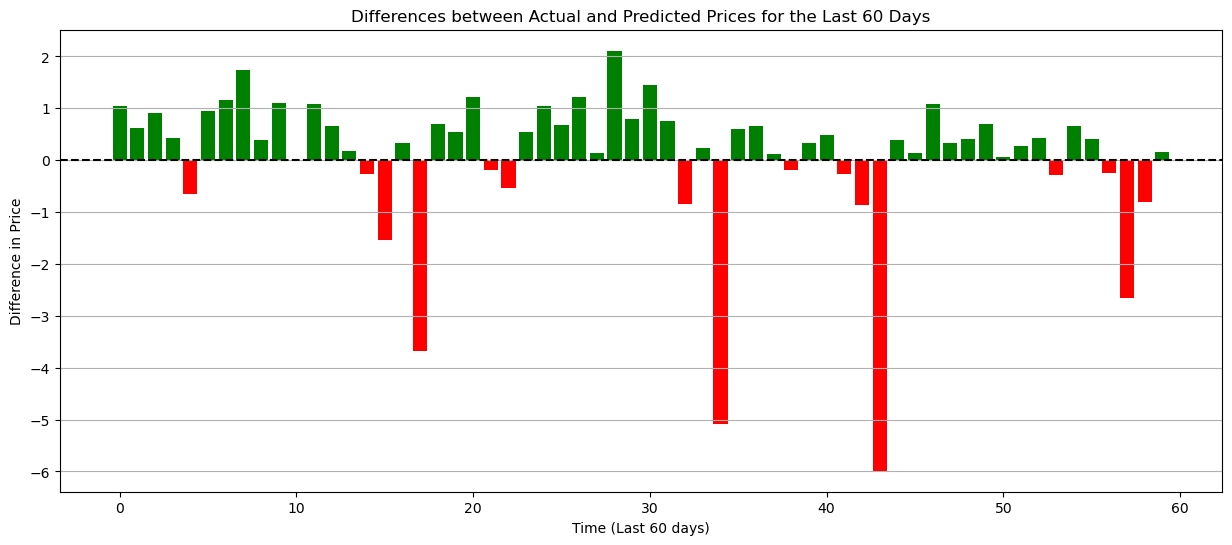

In [101]:
last_60_actual = y_test[-60:]
last_60_predicted =y_pred[-60:]
# Calculate the differences between actual and predicted prices
differences = last_60_actual - last_60_predicted

# Create the plot
plt.figure(figsize=(15, 6))

# Use red for negative differences and green for positive differences
colors = ['red' if diff < 0 else 'green' for diff in differences]

plt.bar(np.arange(len(differences)), differences, color=colors)
plt.axhline(0, color='black', linestyle='--')
plt.title('Differences between Actual and Predicted Prices for the Last 60 Days')
plt.xlabel('Time (Last 60 days)')
plt.ylabel('Difference in Price')
plt.grid(True, axis='y')
plt.show()

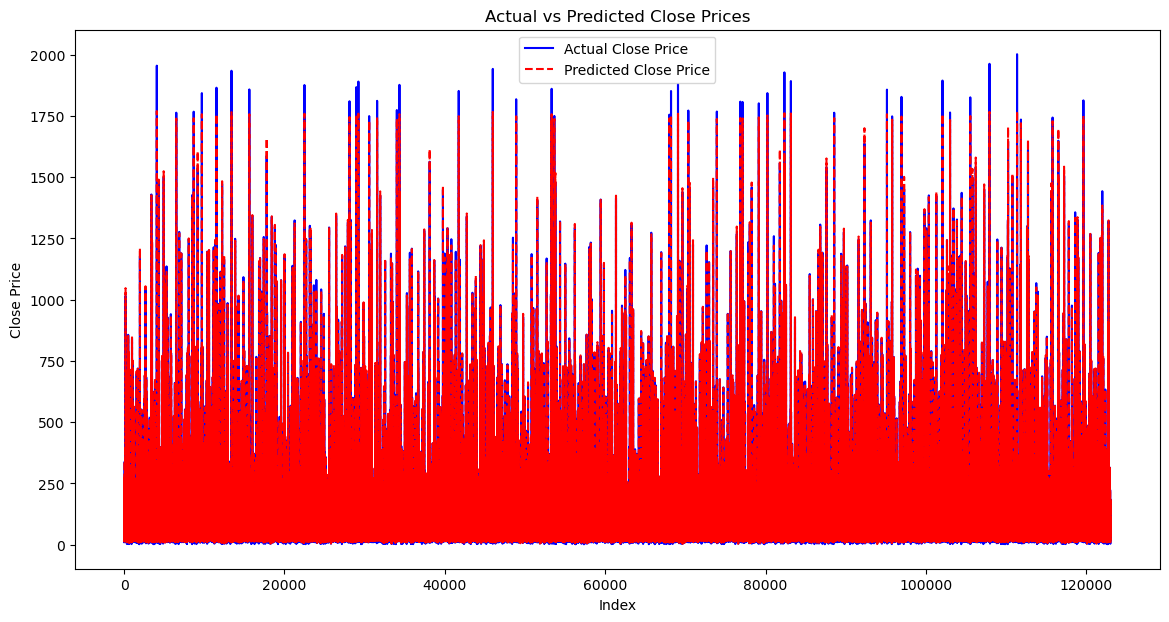

In [103]:
# Create a DataFrame to hold the actual and predicted 'close' prices
comparison_df = pd.DataFrame({'Actual_Close': y_test, 'Predicted_Close': y_pred})

# Sort the DataFrame by the index
comparison_df.sort_index(inplace=True)

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(comparison_df['Actual_Close'], label='Actual Close Price', color='blue')
plt.plot(comparison_df['Predicted_Close'], label='Predicted Close Price', color='red', linestyle='dashed')
plt.title('Actual vs Predicted Close Prices')
plt.xlabel('Index')
plt.ylabel('Close Price')
plt.legend()
plt.show()